Importing Necessary Libraries

In [59]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

Loading the dataset

In [60]:
train_df = pd.read_csv('train.csv')
msp_df = pd.read_csv('msp.csv')

Converting the data type of date column to a datetime type and setting it as the index.

In [61]:
train_df['date']=pd.to_datetime(train_df['date'])
train_df.set_index('date', inplace=True)

This function takes in the timeseries dataframe. It then finds out the the best kind of decomposition
for it and returns the residual values after applying that decomposition.

In [62]:
def residuals_after_decomposition(df):
    
    mul = seasonal_decompose(df.values, model='multiplicative', freq =3).resid[1:-1] # slicing done to remove nans
    addi = seasonal_decompose(df.values, model='additive', freq =3).resid[1:-1] #slicing done to remove nans
    
    mul_total_acf = np.linalg.norm(acf(mul)) #finding out the auto-correlation factor for multiplicative residuals.
    addi_total_acf = np.linalg.norm(acf(addi)) # and getting their L2 norm (to avoid negative values)
    
    if(mul_total_acf<addi_total_acf): # the decomposition with lesser acf in residuals is better.
        print('multiplicative')
        return mul
    else:
        print('additive')
        return addi

The function takes a timeseries as input and runs Dickey-Fuller test on it.
It returns results of the test and plots rolling mean and variance.
If Test Statistic is less than critical value of x% we can say with (100-x)% confidence that the
timeseries is stationery. ( i.e, its seasonality and trend have been removed.)

In [63]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    
    rolmean = pd.rolling_mean(timeseries, window=3)
    rolstd = pd.rolling_std(timeseries, window=3)
    
    #Plot rolling statistics:
    
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

First, let us see if for a pair of APMC And Commodity, we have non-stationarity or not.
Let us take our running example of gram and Mumbai

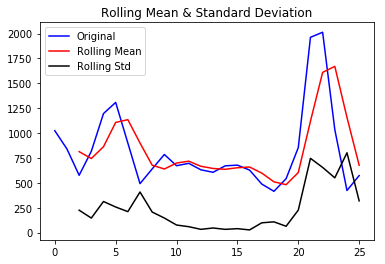

Results of Dickey-Fuller Test:
Test Statistic                 -2.111064
p-value                         0.240089
#Lags Used                      2.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64


In [64]:
df = train_df.groupby(['Commodity','APMC']).get_group(('Cabbage','Mumbai'))[['modal_price']]
df.sort_index(inplace=True)
test_stationarity(df.iloc[:,0].values)

Our test Statistic is greater than Critical Value of 10%. The data is not stationery. 
Let us remove stationarity.

In [65]:
residual = better_decomposition_type(df)

additive


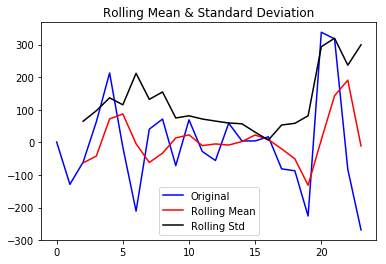

Results of Dickey-Fuller Test:
Test Statistic                 -4.168091
p-value                         0.000746
#Lags Used                      3.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64


In [66]:
test_stationarity(residual)

The test statistic is now lesser than Critical Value of 1%. This means that with 99% confidence,
we can now conclude that our data is stationery, ie, Seasonality and Trend have been removed.

Let us test this on another pair. Garlic prices in Nagpur.

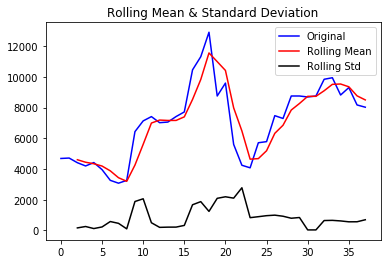

Results of Dickey-Fuller Test:
Test Statistic                 -2.844865
p-value                         0.052145
#Lags Used                      2.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


In [67]:
df = train_df.groupby(['Commodity','APMC']).get_group(('Garlic','Nagpur'))[['modal_price']]
df.sort_index(inplace=True)
test_stationarity(df.iloc[:,0].values)

In [68]:
residual = better_decomposition_type(df)


multiplicative


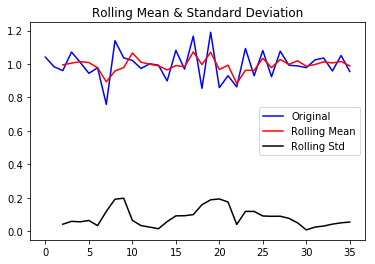

Results of Dickey-Fuller Test:
Test Statistic                 -3.660341
p-value                         0.004707
#Lags Used                      5.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


In [69]:
test_stationarity(residual)

Again, we see that after using residual values post the optimal decomposition our data becomes stationery with
trend and seasonality removed. We also observe smoothed out rolling means and standard deviations.

We can do this for as many Commodity-APMC pairs we want and use the new residual values, that are stationery
with their seasonality and trend removed